In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import statistics
import warnings

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import statistics
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r0927846, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [101]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [4]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [5]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [6]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [116]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [117]:
# parameter to play with 
FACE_SIZE = (150, 150)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)



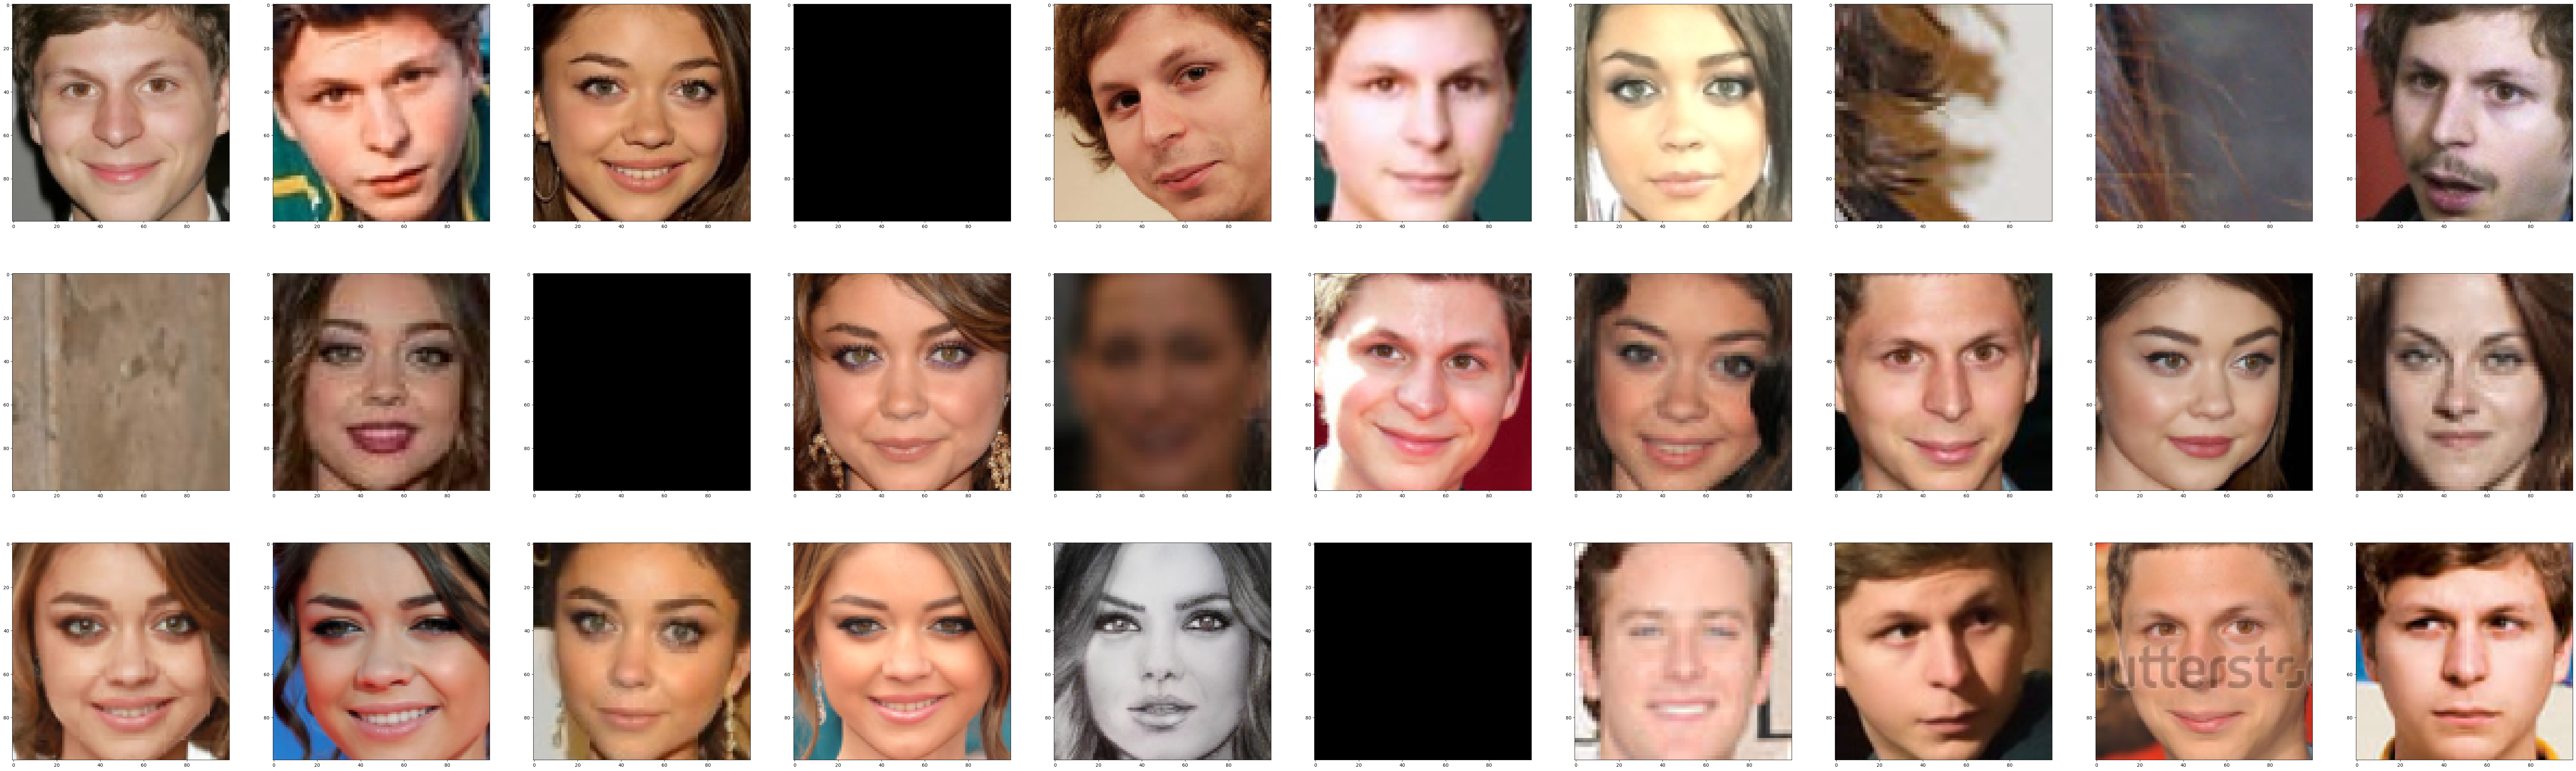

In [123]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=30, imgs_per_row=10)

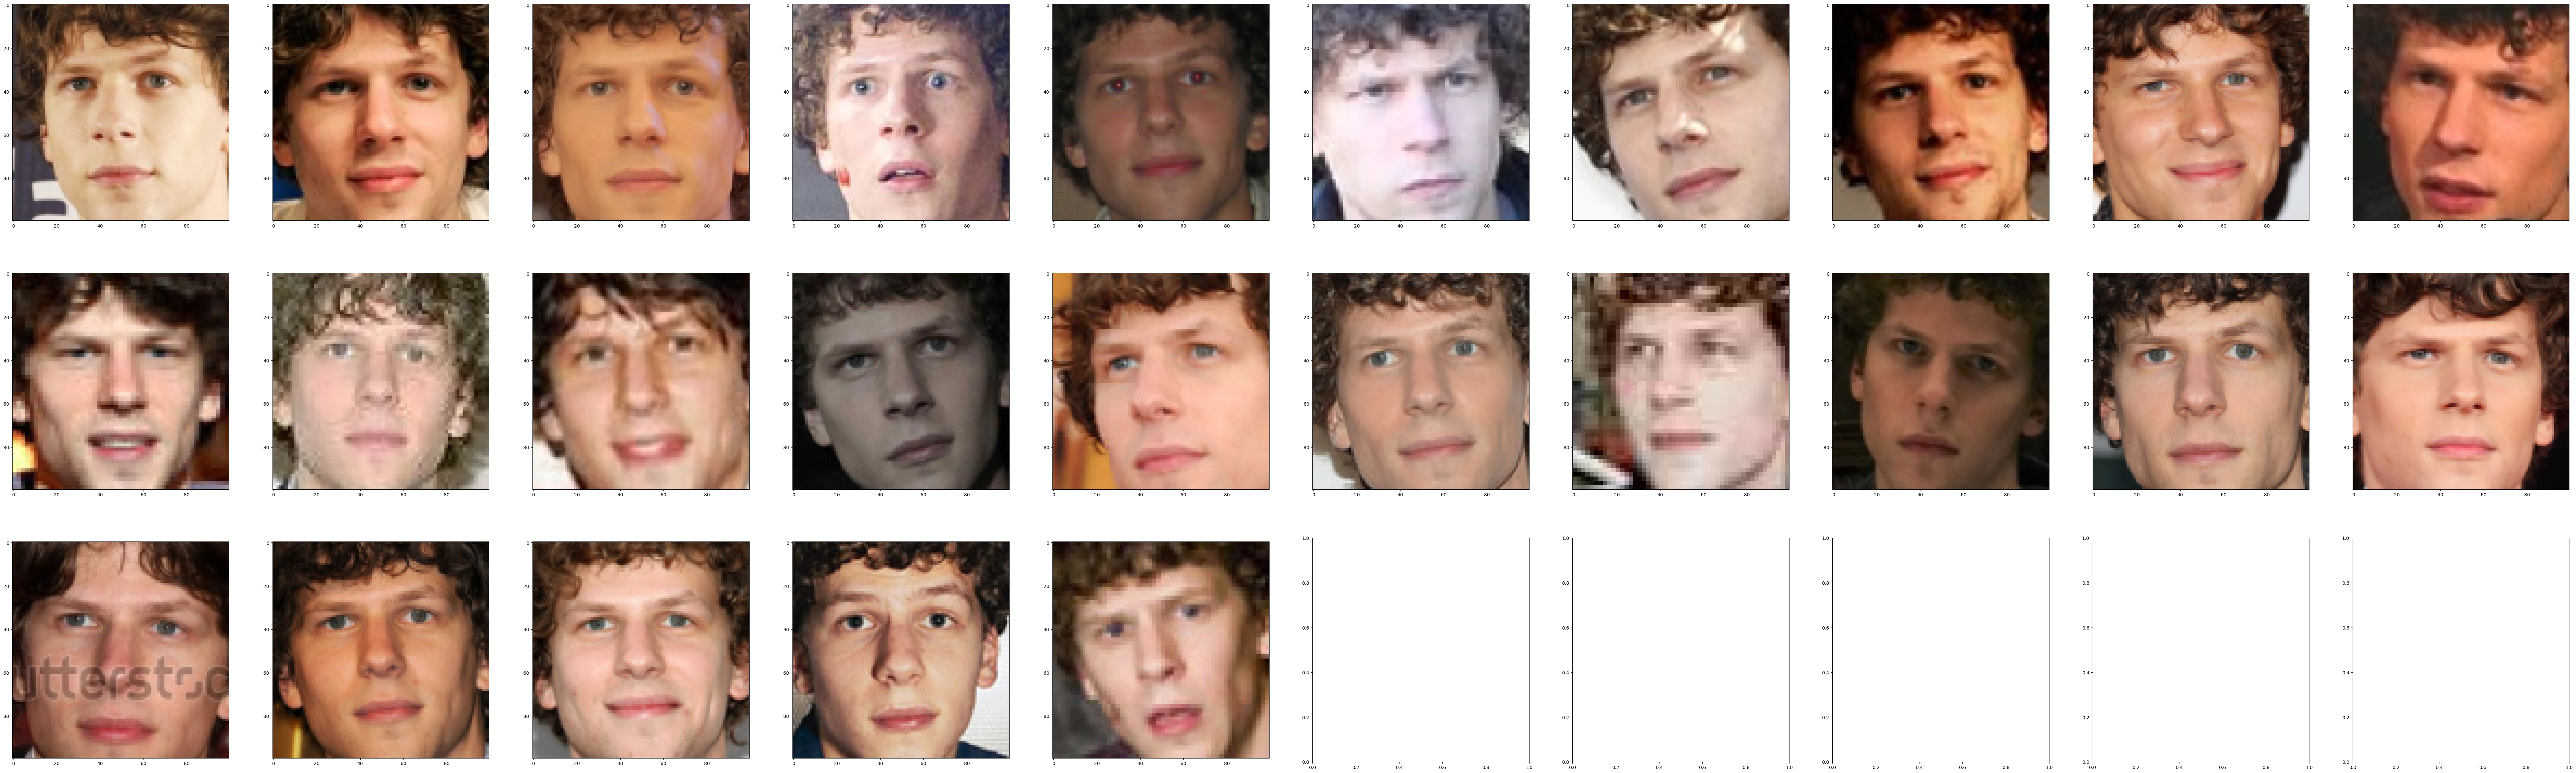

In [120]:
# plot faces of Jesse
# 6, 12?, 15, 18, 27

# a = train_y[train_y == 1]
# for i in [6, 12, 15, 18, 27]:
#     np.put(a, i, 0)
# train_y[train_y == 1] = a

plot_image_sequence(train_X[train_y == 1], n=len(train_X[train_y == 1]), imgs_per_row=10)

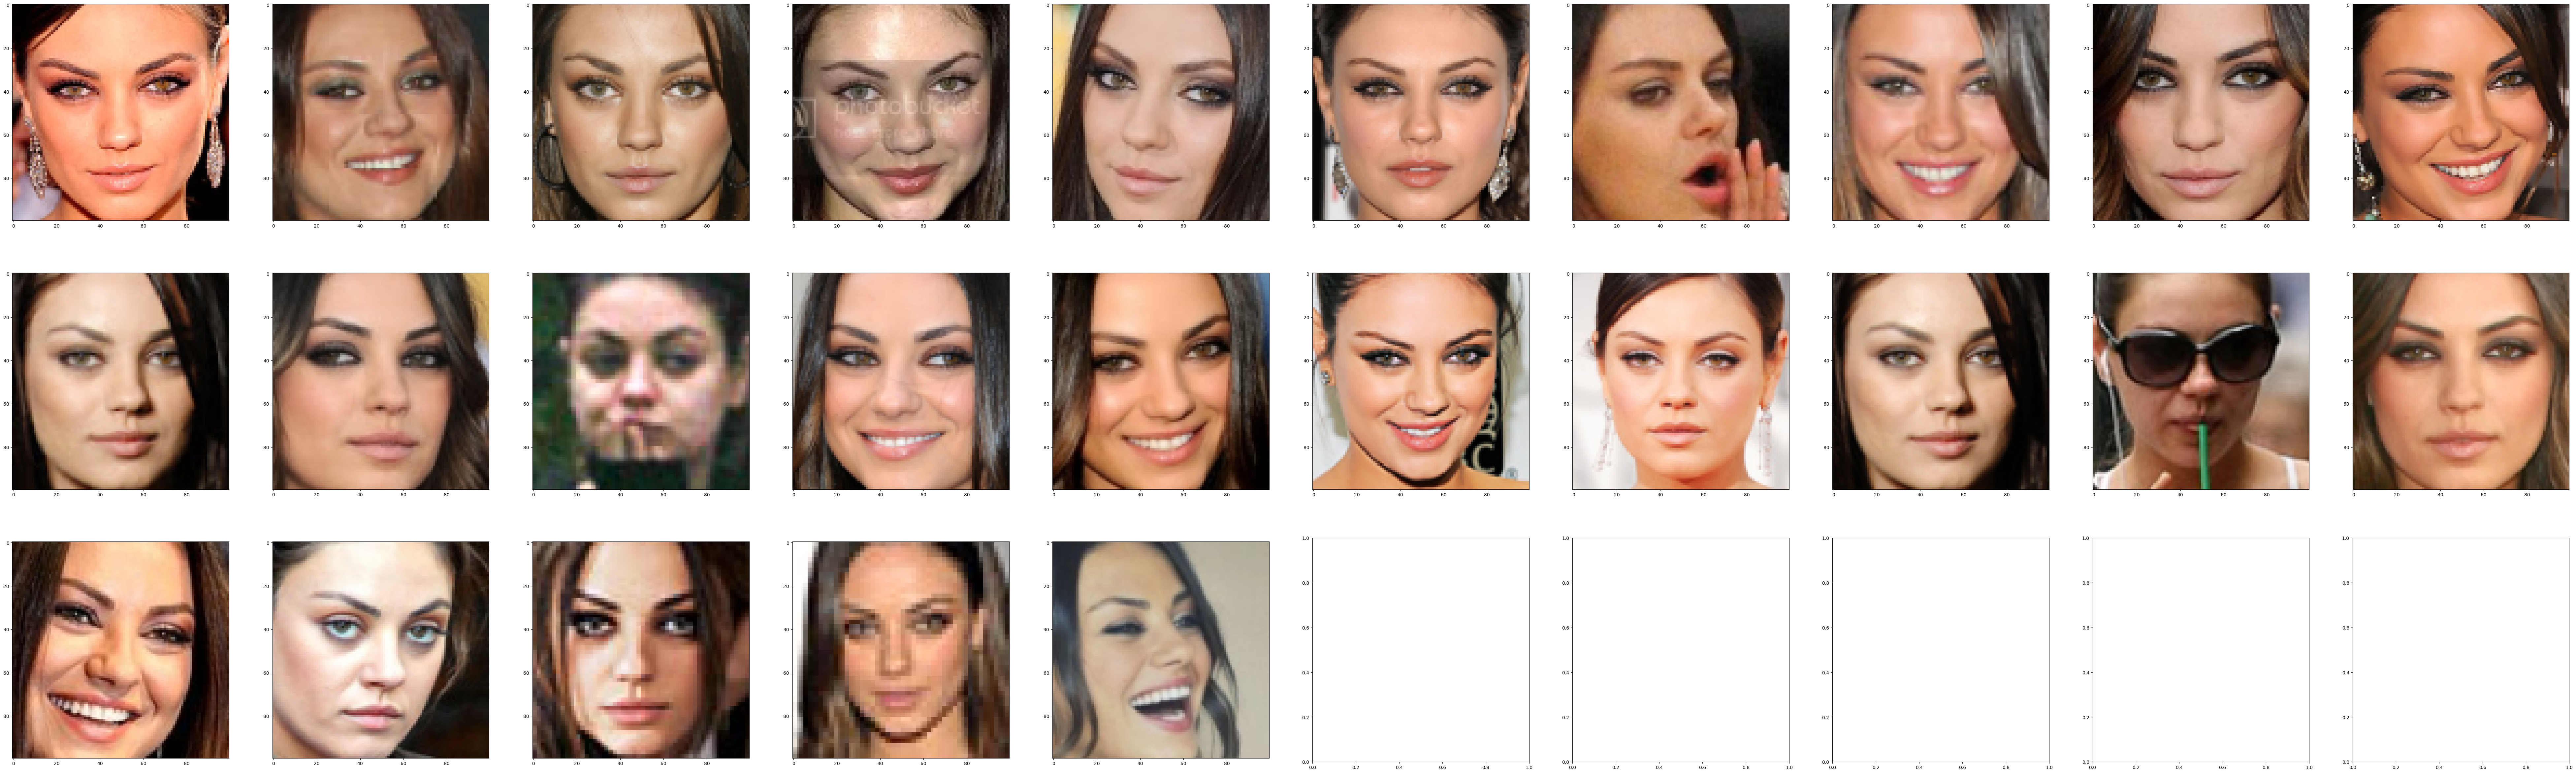

In [122]:
# plot faces of Mila
# 5?, 7?, 15, 24

# a = train_y[train_y == 2]
# for i in [5, 7, 15, 23, 24]:
#     np.put(a, i, 0)
# train_y[train_y == 2] = a



plot_image_sequence(train_X[train_y == 2], n=len(train_X[train_y == 2]), imgs_per_row=10)

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [125]:
# save preprocessed data
prep_path = '/kaggle/working/prepped_data/'
if not os.path.exists(prep_path):
    os.mkdir(prep_path)
    
np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
np.save(os.path.join(prep_path, 'test_X.npy'), test_X)



In [3]:
# load preprocessed data
prep_path = '/kaggle/working/prepped_data/'
if not os.path.exists(prep_path):
    os.mkdir(prep_path)
train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
test_X = np.load(os.path.join(prep_path, 'test_X.npy'))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/prepped_data/train_X.npy'

Now we are ready to rock!

# LABELING TEST DATA FOR EVAL METRICS --- TEST PURPOSES ONLY, DELETE FROM FINAL VERSION

In [241]:
val_X = test_X[-50:]

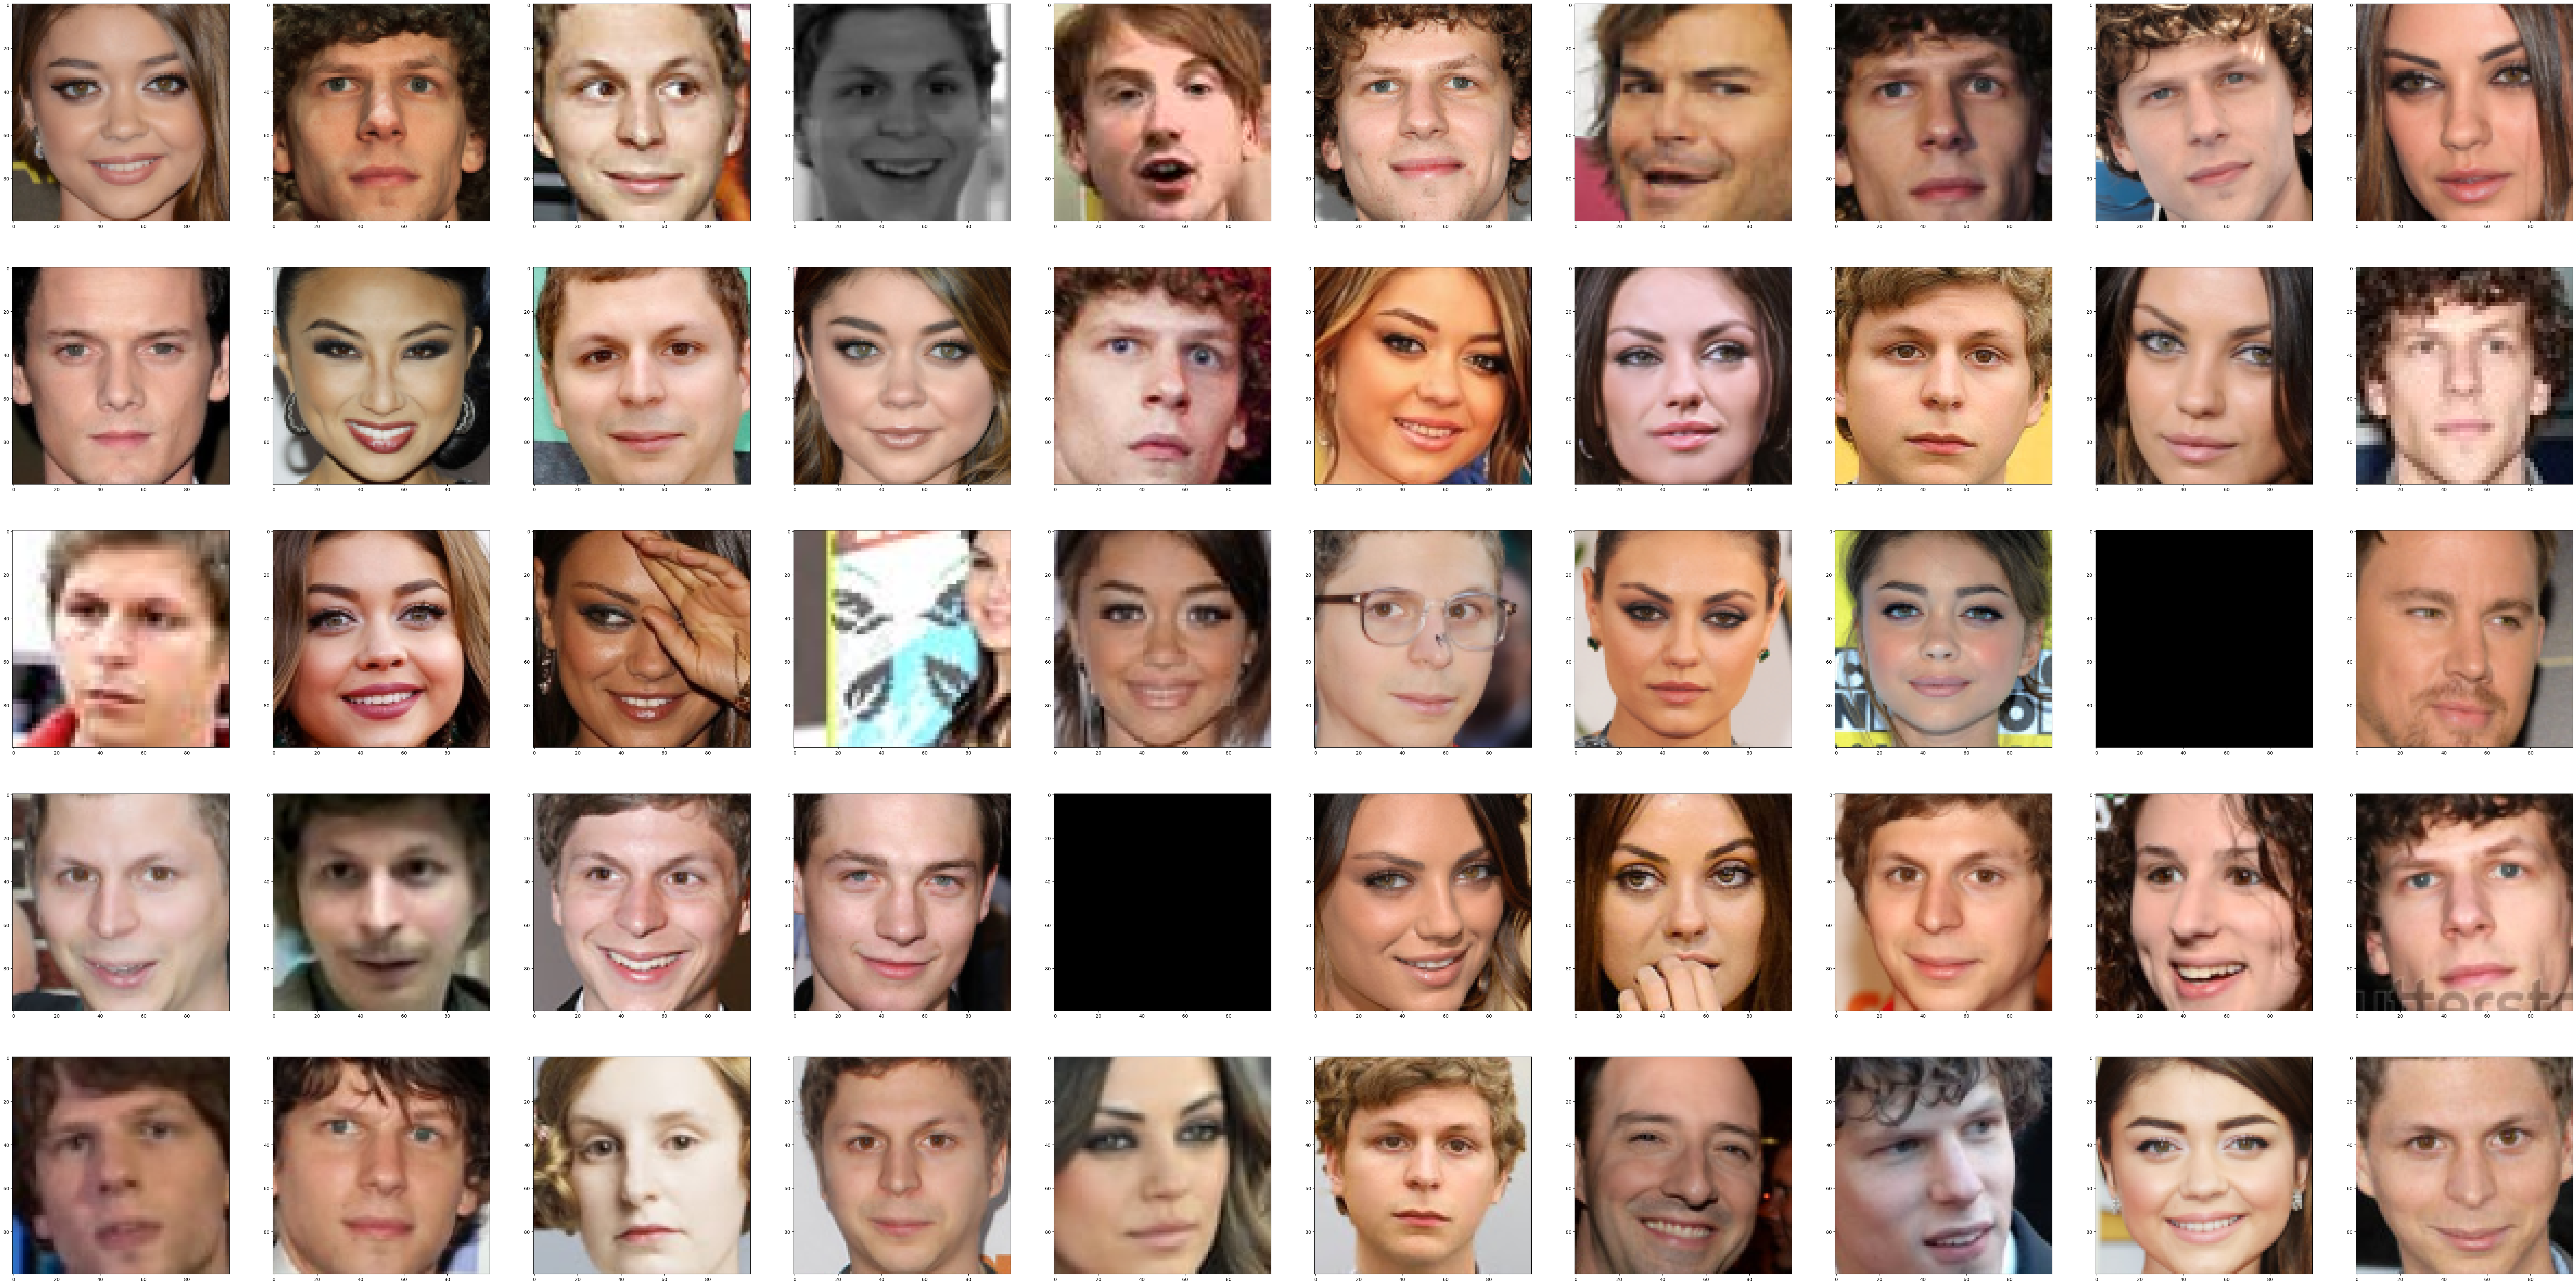

In [242]:
plot_image_sequence(val_X, n=50, imgs_per_row=10)

In [245]:
# 0: unidentified, 1:jesse, 2:mila
val_y = [0, 1, 0, 0, 0, 1, 0, 1, 1, 2,
         0, 0, 0, 0, 1, 0, 2, 0, 2, 1,
         0, 0, 2, 0, 0, 0, 2, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 1, 0, 0, 2, 0, 0, 1, 0, 0]
val_y = np.asarray(val_y)
val_y = keras.utils.to_categorical(val_y, num_classes = 3)

In [115]:
val_y.shape

(50, 3)

In [149]:
if False:
    np.save(os.path.join(prep_path, 'val_X.npy'), val_X)
    np.save(os.path.join(prep_path, 'val_y.npy'), val_y)

In [150]:
if True:
    val_X = np.load(os.path.join(prep_path, 'train_y.npy'))
    val_y = np.load(os.path.join(prep_path, 'test_X.npy'))

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [21]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
...

In [15]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(**params):
        self.params = params
        
    def transform(self, X):
        raise NotImplmentedError

In [260]:
warnings.simplefilter(action='ignore', category=FutureWarning)
        
class SIFTFeatureExtractor(IdentityFeatureExtractor):
    
    def __init__(self, **params):
        self.params = params
        self.sift = cv2.SIFT_create(
                            nfeatures =  self.params.get('nfeatures'),
                            nOctaveLayers = self.params.get('nOctaveLayers'),
                            contrastThreshold = self.params.get('contrastThreshold'),
                            edgeThreshold = self.params.get('edgeThreshold'),
                            sigma = self.params.get('sigma')
        )
        self.bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)
        
    def transform(self, X, plot=False):
        df = pd.DataFrame(columns=range(len(X)), index=range(len(X)))
        descriptors = []
        for (i, img1) in enumerate(X):
            gray1 = cv2.cvtColor(img1.astype(dtype=np.uint8), cv2.COLOR_BGR2GRAY)
            _, descriptors1 = self.sift.detectAndCompute(gray1, None)
            
            if not plot:
                if descriptors1 is None:
                    print(np.zeros((self.params.get('nfeatures'), 128)).shape)
                    descriptors.append(np.zeros((self.params.get('nfeatures'), 128)))
                elif descriptors1.shape[0] < self.params.get('nfeatures'):
                    a = np.concatenate((descriptors1, np.zeros((self.params.get('nfeatures') - descriptors1.shape[0], 128))))
                    descriptors.append(a)
                else:
    #                 print(f"d1:{descriptors1.shape}")
                    descriptors.append(descriptors1[:self.params.get('nfeatures')])
    
            if plot:
                for (j, img2) in enumerate(X):
                    gray2 = cv2.cvtColor(img2.astype(dtype=np.uint8), cv2.COLOR_BGR2GRAY)
                    _, descriptors2 = self.sift.detectAndCompute(gray2, None)
                    if descriptors1 is None or descriptors2 is None:
                        distance = 999
                    else:
                        matches = self.bf.match(descriptors1, descriptors2)
                        distance = statistics.mean([match.distance for match in matches])

                    df[i][j] = distance
                
        return np.asarray(descriptors), df
    
    
    def __call__(self, X, plot=False):
        return self.transform(X, plot)[0]
    

### 1.1.1. t-SNE Plots
...

In [184]:
sift_extractor = SIFTFeatureExtractor(
                            nfeatures= 10,
                            )


a = sift_extractor(train_X, True)




80
(10, 128)
(10, 128)
(10, 128)
(80, 10, 128)


In [64]:
# Defining TSNE with same seed for reproducibility
seed = 42
tsne = TSNE(random_state = seed) 

# Colours for scatterplot 
palette = sns.color_palette("bright", 3)

<AxesSubplot:xlabel='x', ylabel='y'>

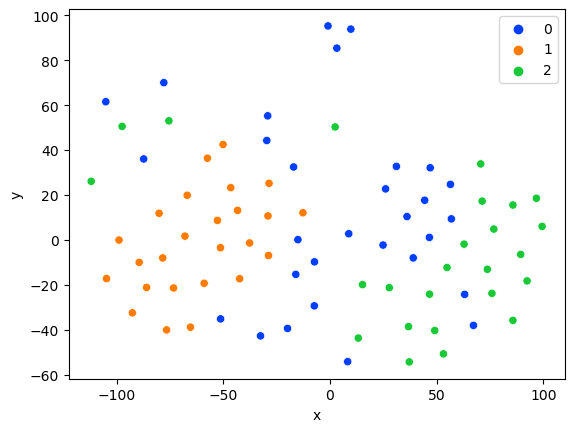

In [261]:
# Defines SIFT extractor with specific hyperparameters
sift_extractor = SIFTFeatureExtractor(
                            nfeatures= None,
                            nOctaveLayers = 4,
                            contrastThreshold = 0.03,
                            edgeThreshold = 20,
                            sigma = 1.8)

#Best Vaues so far:
nOctaveLayers = 4,
contrastThreshold = 0.03
edgeThreshold = 20
sigma = 1.8

# Extracting the features
all_features = sift_extractor.transform(train_X, True)[1]

# Calculates pairs of instances in the new dimensional space
features_low_dimension = tsne.fit_transform(all_features)
df = pd.DataFrame(features_low_dimension, columns=["x","y"])

# Create a Scatter plot
sns.scatterplot(df, x="x", y="y", hue=train_y, legend='full', palette=palette)

In [ ]:
### PUT IN DISCUSSION

# Looking at the effect of SIFT( nOctaveLayers: 3 Default)
acc_TSNE = []
parameter = [3, 2, 4, 5] 

for i in parameter:
    sift_extractor = SIFTFeatureExtractor(
                            nfeatures = None,
                            nOctaveLayers = i,
                            contrastThreshold = None,
                            edgeThreshold = None,
                            sigma = None)
    
    all_features = sift_extractor(train_X)
    features_low_dimension = tsne.fit_transform(all_features)
    df = pd.DataFrame(features_low_dimension, columns=["x","y"])
    acc_TSNE.append(df)

# Plotting
f, ax = plt.subplots(1, len(parameter), figsize=(20,4))
f.suptitle('Effect of varying SIFT-Hyperparameter: nOctaveLayers')

for i, df in enumerate(acc_TSNE):
    sns.scatterplot(ax=ax[i], data=df, x="x", y="y", hue=train_y, legend='full', palette=palette)
    ax[i].set_title(f"Parameter: {parameter[i]}")

### 1.1.2. Discussion
...

## 1.2. Baseline 2: PCA feature extractor
...

In [85]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(self, n_components, data):
        self.n_components = n_components
        self.data = self.preprocess_data(data)
        self.mean = np.mean(self.data, axis=0)
        self.singular, self.eigenfaces = self.compute_vectors()
        
    #THIS FUNCTION IS COMPLETELY COPIED BY SCIKIT-LEARN
    def svd_flip(self, u, v, u_based_decision=True):  
        if u_based_decision:
            # columns of u, rows of v
            max_abs_cols = np.argmax(np.abs(u), axis=0)
            signs = np.sign(u[max_abs_cols, range(u.shape[1])])
            u *= signs
            v *= signs[:, np.newaxis]
        else:
            # rows of v, columns of u
            max_abs_rows = np.argmax(np.abs(v), axis=1)
            signs = np.sign(v[range(v.shape[0]), max_abs_rows])
            u *= signs
            v *= signs[:, np.newaxis]
        return u, v
    
    def compute_vectors(self):
        data = self.data - self.mean
        U, S, Vt = np.linalg.svd(data, full_matrices=False)
        U, Vt = self.svd_flip(U, Vt)
        eig_vecs = Vt[:self.n_components]
        #return the singular values and first n eig_vectors
        return S, eig_vecs
    
    def transform(self, X):
        #transform data into set of features
        X_gray = self.preprocess_data(X)
        new_X = X_gray - self.mean
        return np.dot(new_X, self.eigenfaces.T)
    
    def inverse_transform(self, X):
        #transform set of features into data
        
        return np.dot(X, self.eigenfaces) + self.mean
    
    
    def preprocess_data(self, X):
        
        X_gray = np.zeros(X.shape[:-1])
        for i in range(X.shape[0]): 
            X_gray[i] = cv2.cvtColor(X[i].astype(np.uint8), cv2.COLOR_BGR2GRAY) 
            
        facematrix = []
        for face in X_gray:
            facematrix.append(face.flatten())
        facematrix = np.array(facematrix)
        
        return facematrix

(1, 100, 100, 3)
Best match 1 with Euclidean distance 2463.047036


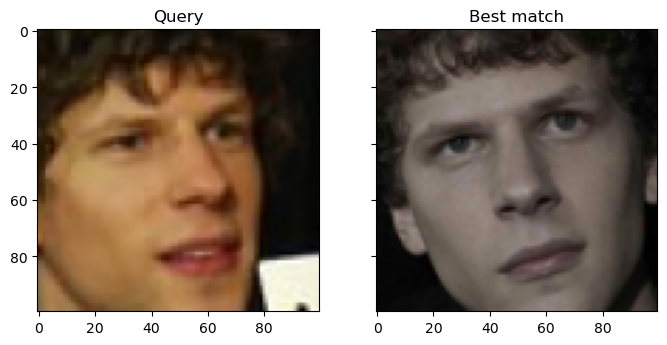

In [115]:
pca1 = PCAFeatureExtractor(5, train_X)
#THIqueryS IS A TEST FOR THE PCA
weights = pca1.transform(train_X)
# Test on out-of-sample image of existing class
query = np.expand_dims(test_X[11], axis=0)

print(query.shape)
query_weight = pca1.transform(query)
euclidean_distance = np.linalg.norm(weights - query_weight, axis=1)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (train_y[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query[0], cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(train_X[best_match], cmap="gray")
axes[1].set_title("Best match")
plt.show()

## choosing the right number of components

This could be done either by testing different values and choosing the one that leads to greater accuracy or by analyzing the singular values. Each singular value indicates how much information does the corresponding eigenvector contain. From the following plot we notice that after the 5th vector the ammount of information start to decrease less rapidly so a good number of components would probably be around 5. THis could be a good trade-off between number of features and accuracy.

In [ ]:
#plotting first 15 singular values
plt.plot(range(15), pca1.singular[:15])

### 1.2.1. Eigenface Plots
...

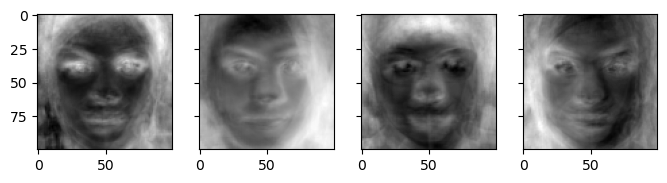

In [126]:
fig, axes = plt.subplots(1,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(4):
    axes[i].imshow(pca1.eigenfaces[i].real.reshape((100,100)), cmap="gray")
plt.show()

In [129]:
# WORK IN PROGRESS

values = [2, 5, 15, 30, 80]
plotPCA = [PCAFeatureExtractor(i, train_X) for i in values]
query = test_X[8]
fig, axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(9,6))
axes[0][0].imshow(query), cmap="gray")
axes[0][0].set_title("Original face")
features = [plotPCA[i].transform(query) for i in range(5)]
inverse = [plotPCA[i].inverse_transform(features[i]) for i in range(5)]
axes[0][1].imshow(inverse[0].reshape((100,100)), cmap="gray")
axes[0][1].set_title("using 2 eigenfaces")
axes[0][2].imshow(inverse[1].reshape((100,100)), cmap="gray")
axes[0][2].set_title("using 5 eigenfaces")
axes[1][0].imshow(inverse[2].reshape((100,100)), cmap="gray")
axes[1][0].set_title("using 15 eigenfaces")
axes[1][1].imshow(inverse[3].reshape((100,100)), cmap="gray")
axes[1][1].set_title("using 30 eigenfaces")
axes[1][2].imshow(inverse[4].reshape((100,100)), cmap="gray")
axes[1][2].set_title("using 80 eigenfaces")

SyntaxError: invalid syntax (3099318472.py, line 5)

### 1.2.2. Feature Space Plots
...

### 1.2.3. Discussion
...

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [26]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [18]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
...

In [ ]:
class SVM:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)

In [19]:
# COMPACT MODEL (can be even more compact)

def create_model_A(num_classes, input_shape):
    
    model = keras.models.Sequential()
    
    model.add(layers.Rescaling(1.0/255 , input_shape=input_shape))
    
    model.add(layers.Conv2D(32, (3, 3), padding="same"))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), padding="same"))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding="same"))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(layers.Dense(64))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16))
    model.add(layers.Activation('relu'))
    
    
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    model.add(layers.Dense(units))
    model.add(layers.Activation(activation))
    
    
    return {"model": model, 
            "num_classes": num_classes, 
            "input_shape": input_shape}

In [20]:
# HUGE MODEL

def create_model_B(num_classes, input_shape):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    
    
    return {"model":keras.Model(inputs, outputs), 
            "num_classes": num_classes, 
            "input_shape": input_shape}

In [23]:
# TRANSFER LEARNING - Xception, VGG16


def create_model_C(num_classes, input_shape, base_model=0):
    
    inputs = keras.Input(shape=input_shape)
    
    if base_model == 0:
        base_model = keras.applications.Xception(
        weights='imagenet',  
        input_shape=input_shape,
        include_top=False)
        
        base_model.trainable = False
        
        x = keras.applications.xception.preprocess_input(inputs)
        
        
    else: # base_model == 1:
        base_model = keras.applications.vgg16.VGG16(weights='imagenet', input_shape=input_shape, include_top=False)
        
        base_model.trainable = False
        
        x = keras.applications.vgg16.preprocess_input(inputs)
    
    
    x = base_model(x, training=False)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    outputs =layers.Dense(units, activation=activation)(x)
    
    
    return {"model": keras.Model(inputs, outputs), 
            "num_classes": num_classes, 
            "input_shape": input_shape}

In [325]:

def create_model_D(num_classes, input_shape):
    
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.LayerNormalization(axis=-1)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    outputs =layers.Dense(units, activation=activation)(x)
    
    
    return {"model": keras.Model(inputs, outputs), 
            "num_classes": num_classes, 
            "input_shape": input_shape}

In [319]:
class Posterity:
    
    def __init__(self, model, num_classes, input_shape):
        
        self.model = model
        self.num_classes = num_classes
        self.input_shape = input_shape
    
    
    
    def fit(self, X, y, epoch=10, lr=1e-3, batch_size=4, augment_data=False, val_ds=None):
        
        y_OHE = keras.utils.to_categorical(y, num_classes = self.num_classes)
        
#         if augment_data:
            
#             datagen = keras.preprocessing.image.ImageDataGenerator(
#                 rotation_range=25,
# #                 width_shift_range=0.05,
# #                 height_shift_range=0.05,
#                 shear_range=0.1,
#                 zoom_range=0.1,
#                 horizontal_flip=True,
#                 brightness_range=[0.95, 1.05],
#                 fill_mode='nearest')
            
#         else:
#             datagen = keras.preprocessing.image.ImageDataGenerator()
        
            
            
#         train_data = datagen.flow(x=X, y=y_OHE, batch_size=batch_size, shuffle=True)
            

#         callbacks = [
#             keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
#         ]
        
        self.model.compile(
            optimizer=keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
#             optimizer=keras.optimizers.experimental.AdamW(lr=lr,  weight_decay=5e-3),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )
        
          # one hot encoded
            
        

        return self.model.fit(
            x=X,
            y=y_OHE,
            batch_size=batch_size,
            epochs=epoch,
#             callbacks=callbacks,
            validation_data=val_ds,
        )
    
        
    def predict(self, X):
        pred = self.model.predict(X)
#         print(pred)
#         print(np.argmax(pred, axis=-1))

        return np.argmax(pred, axis=-1)

    def __call__(self, X):
        return self.predict(X)

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [329]:
# feature_extractor  = SIFTFeatureExtractor(
#                             nfeatures= 15,
#                             nOctaveLayers = 4,
#                             contrastThreshold = 0.03,
#                             edgeThreshold = 20,
#                             sigma = 1.8)
feature_extractor = PCAFeatureExtractor(30, train_X)
# classifier = RandomClassificationModel()

a = feature_extractor(train_X[0:2])
print(feature_extractor(val_X).shape)

kwargs = create_model_D(num_classes=3, input_shape=a.shape[1:]) # we do [1:] to NOT consider the batch size in the model
print(kwargs["model"].summary())
classifier = Posterity(**kwargs)

val_ds = (feature_extractor(val_X), val_y)
# train the model on the features
classifier.fit(feature_extractor(train_X), train_y, epoch=25, lr=4e-3, batch_size=32, augment_data=False, val_ds=val_ds)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

(50, 30)
Model: "model_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_83 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_210 (Dense)           (None, 64)                1984      
                                                                 
 layer_normalization_24 (Lay  (None, 64)               128       
 erNormalization)                                                
                                                                 
 dropout_100 (Dropout)       (None, 64)                0         
                                                                 
 dense_211 (Dense)           (None, 64)                4160      
                                                                 
 dense_212 (Dense)           (None, 128)               8320      
                                                 

In [330]:
# evaluate performance of the model on the training set
train_y_star = model(train_X)
print(train_y_star)

print(f"The performance on the training set is {accuracy_score(train_y, train_y_star):.2f}. This however, does not tell us much about the actual performance (generalisability).")

3/3 [==============================] - 0s 2ms/step
[2 2 0 2 0 1 2 1 2 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 2 1 0 2 2 2 0 2 1 0 0
 2 2 2 0 0 0 2 0 1 2 0 1 0 2 0 1 1 1 0 2 2 0 0 1 2 1 0 0 0 1 2 1 1 0 0 1 1
 2 2 0 2 2 0]
The performance on the training set is 0.99. This however, does not tell us much about the actual performance (generalisability).


In [277]:
# predict the labels for the test set 
test_y_star = model(test_X)

57/57 [==============================] - 0s 1ms/step


# 5. Publishing best results

In [278]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

class
id         
0         1
1         0
2         0
3         1
4         1
...     ...
1811      0
1812      0
1813      1
1814      0
1815      0

[1816 rows x 1 columns]

In [280]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
